# **¿Cómo construir un modelo de predicción para los incumplimientos de préstamos en Lending Club?**

## Objetivos

El objetivo de este caso es implementar clasificadores como regresión logística, SVM, árboles de decisión, random forest y algoritmos de boosting como LightGBM, y determinar cuál de ellos es el mejor para el problema de predicción de impagos de préstamos de Lending Club. Se utilizará validación cruzada y métricas de desempeño cuantitativas para evaluar y comparar los modelos.

Durante el estudio de caso, se comenzará creando un clasificador base con regresión logística. Posteriormente, se implementarán los demás algoritmos y se validarán los resultados para seleccionar el mejor modelo basándose en su rendimiento cuantitativo. Poder determinar y justificar la elección del mejor modelo es un paso fundamental en el análisis de datos.



## Introducción


**Contexto del Negocio.** El objetivo es construir un modelo de clasificación que determine si un usuario incumplirá con el pago de su préstamo, ya que predecir la probabilidad de incumplimiento es clave para el negocio de préstamos P2P. La predicción precisa de estos incumplimientos es esencial para mejorar la gestión de riesgos y el proceso de otorgamiento de créditos.

**Contexto Analítico.** La tarea consiste en implementar y comparar diferentes algoritmos de clasificación, como regresión logística, SVM, árboles de decisión, random forest y LightGBM, con el fin de seleccionar el mejor modelo mediante validación cruzada. Este proceso garantizará que el algoritmo final sea robusto y capaz de generalizar para datos futuros.




## Evaluando nuestro modelo de regresión logística

In [56]:
import pandas as pd
import pydotplus
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from io import StringIO
from IPython.display import Image, SVG
from graphviz import Source
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from scipy.stats import chi2_contingency, norm
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from statsmodels.formula.api import ols
from sympy import var, plot_implicit, Eq
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ignore log(0) and divide by 0 warning
np.seterr(divide='ignore');

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
ubic = '/content/drive/MyDrive/Colab Notebooks//Lending_club_cleaned_2.xlsx'

df = pd.read_excel(ubic)

dtype = {'loan_status':'category', 'annual_inc':'float','verification_status':'category', 'emp_length':'category','home_ownership':'category', 'int_rate':'object','loan_amnt':'float', 'purpose':'category','term':'category', 'grade':'category'}

#df['int_rate'] = df['int_rate'].str.rstrip('%').astype('float')

In [77]:
#print(df.head())
#df.dtypes
#df.info()




['Verified' 'Source Verified' 'Not Verified']



### Ejercicio:

Grafique los boxplots de las siguientes variables continuas: `loan_amnt`, `annual_inc` y `int_rate`, separadas por incumplidores y no incumplidores. Analice las distribuciones y observe si hay diferencias notables entre las dos clases. ¿Existen outliers en alguna de las variables? ¿Qué implicaciones pueden tener estas diferencias y outliers en el modelo de regresión logística que se va a entrenar? ¿Sería necesario realizar algún tipo de transformación o tratamiento de los datos antes de continuar con el análisis?



<ipython-input-118-c78669207b10>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl2 = sns.boxplot(x="loan_status", y = feature, data = df, palette="Blues")
<ipython-input-118-c78669207b10>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl2.set_xticklabels(pl2.get_xticklabels(), rotation=40, ha="right");
<ipython-input-118-c78669207b10>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl2 = sns.boxplot(x="loan_status", y = feature, data = df, palette="Blues")
<ipython-input-118-c78669207b10>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl2.set_xticklabels(pl2.get_xticklabels(), rotation=40, ha="right");
<ipython-input-118-c78669207b10>:6: Future

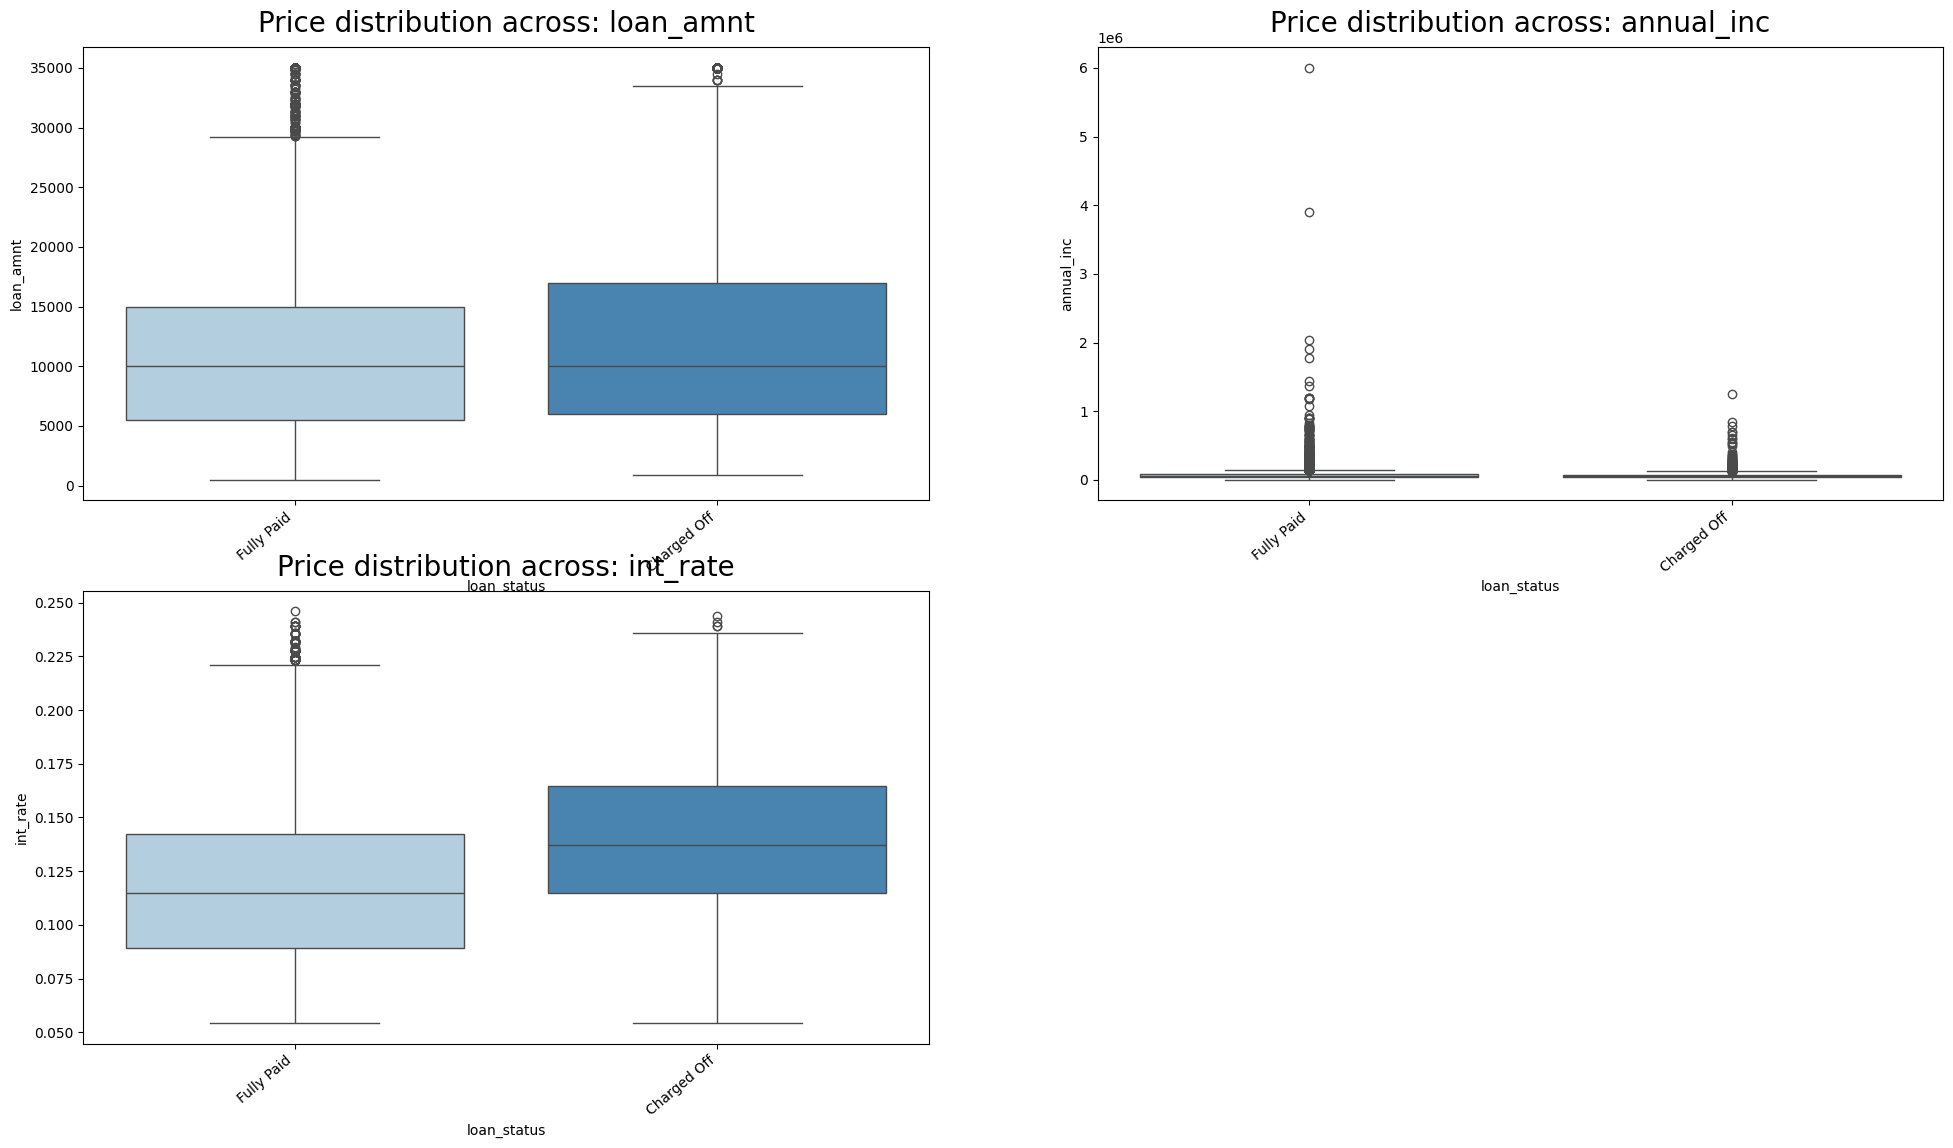

In [118]:
# Numeric categorical features
plt.figure(figsize=(24,20))
varstolook = ['loan_amnt', 'annual_inc', 'int_rate']
for i,feature in enumerate(varstolook):
    plt.subplot(3,2,i+1)
    pl2 = sns.boxplot(x="loan_status", y = feature, data = df, palette="Blues")
    pl2.set_xticklabels(pl2.get_xticklabels(), rotation=40, ha="right");
    plt.title("Price distribution across: " + feature, fontsize=20, verticalalignment='bottom');

In [139]:
#CODIFICACIÓN DE VARIABLES CATEGÓRICAS

# Codificación *one-hot* para variables categóricas
df2 = df[['loan_status','loan_amnt','int_rate','annual_inc','home_ownership','grade','verification_status','emp_length','term']]

df_encoded = pd.get_dummies(df2,columns=['verification_status', 'home_ownership' , 'grade' ,'emp_length', 'term'])
# Codificación binaria para variables binarias
df_encoded.replace({'loan_status': {"Charged Off": 0, "Fully Paid": 1},
             }, inplace=True)

# Paso 3: Agregar la columna 'loan_status' al DataFrame codificado
#df_encoded['loan_status'] = df2['loan_status']

#df['loan_status'].cat.code





In [160]:
#NORMALIZACIÓN DE VARIABLES CONTINUAS

# Parametros y etiquetas iniciales de nuestra regresión lineal
X = df_encoded.drop(['loan_status'],axis=1)
y = df_encoded[['loan_status']].values.ravel()

training_mean = X.mean()
training_std = X.std()

X_norm = (X - training_mean) / training_std
df_log = X_norm
#X_vali = (X_vali - training_mean) / training_std
#X_test = (X_test - training_mean) / training_std
df_log.head()

,loan_amnt,int_rate,annual_inc,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,...,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,term_36 months,term_60 months
0,-0.843862,-0.378954,-0.710290,-0.861962,-0.583021,1.457598,-0.896888,-0.050382,-0.281663,1.044673,...,-0.344111,-0.312521,-0.304535,-0.247316,-0.219232,-0.199742,-0.18336,-0.366708,0.606986,-0.606986
1,-1.178519,0.863143,-0.616866,-0.861962,1.715159,-0.686042,-0.896888,-0.050382,-0.281663,1.044673,...,-0.344111,-0.312521,-0.304535,-0.247316,-0.219232,-0.199742,-0.18336,2.726893,-1.647442,1.647442
2,-1.191906,1.048651,-0.893213,1.160114,-0.583021,-0.686042,-0.896888,-0.050382,-0.281663,1.044673,...,-0.344111,-0.312521,-0.304535,-0.247316,-0.219232,-0.199742,-0.18336,-0.366708,0.606986,-0.606986
3,-0.174546,0.384586,-0.317912,-0.861962,1.715159,-0.686042,-0.896888,-0.050382,-0.281663,1.044673,...,-0.344111,-0.312521,-0.304535,-0.247316,-0.219232,-0.199742,-0.18336,-0.366708,0.606986,-0.606986
4,-1.111588,0.169505,0.161661,-0.861962,1.715159,-0.686042,-0.896888,-0.050382,-0.281663,1.044673,...,-0.344111,-0.312521,-0.304535,-0.247316,-0.219232,-0.199742,-0.18336,-0.366708,-1.647442,1.647442


In [164]:
X_train, X_test, y_train, y_test = train_test_split(df_log, y, test_size=0.2)

#Ahora vamos a entrenar nuestro conjunto de datos
#creacion del modelo
log_reg = LogisticRegression()
#entrenamiento del modelo
lr_model=log_reg.fit(X_train, y_train)

In [168]:
lr_model.summary

AttributeError: 'LogisticRegression' object has no attribute 'summary'

In [162]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Crear el modelo de regresión lineal
model_linear = LogisticRegression()

# Ajustar el modelo a los datos de entrenamiento
model_linear.fit(X_train, y_train)

# Hacer predicciones en el conjunto de entrenamiento
y_train_pred = model_linear.predict(X_train)

# Mostrar los coeficientes y el intercepto del modelo
print(f"Coeficientes: {model_linear.coef_}")
print(f"Intercepto: {model_linear.intercept_}")

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2: {r2}")

Coeficientes: [[-0.01471212 -0.39101402  0.39131239  0.00302222 -0.00130546 -0.00198623
   0.0179501  -0.0405319  -0.00376983 -0.01181421  0.11230693 -0.0072776
  -0.04586809 -0.05232291 -0.01974651 -0.02250323 -0.00200436 -0.00152058
  -0.05492602  0.02558088  0.02430189  0.0107953   0.00343293  0.02251782
  -0.01112136 -0.0121146   0.01354884  0.0028226   0.09743266 -0.09743266]]
Intercepto: [1.96400387]
Mean Squared Error: 0.1418098436894458
R^2: -0.16524291574154204


In [171]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import numpy as np

# Asegúrate de que df_log y y estén definidos
X = df_log  # Variables normalizadas
y = df_encoded['loan_status']  # Variable objetivo

# Crear los pliegues estratificados
kfold = StratifiedKFold(n_splits=10)
scores = []

# Definir el modelo
log_reg = LogisticRegression()

# Validación cruzada
for k, (train_index, test_index) in enumerate(kfold.split(X, y)):
    # Dividir los datos en entrenamiento y prueba para el pliegue actual
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Entrenar el modelo en los datos de entrenamiento del pliegue
    log_reg.fit(X_train_fold, y_train_fold)

    # Evaluar el modelo en los datos de prueba del pliegue
    score = log_reg.score(X_test_fold, y_test_fold)

    # Guardar el score
    scores.append(score)

    # Imprimir el rendimiento por pliegue
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train_fold), score))

# Calcular la media y la desviación estándar después de los pliegues
mean = np.mean(scores)
std = np.std(scores)

# Imprimir el resultado final de la validación cruzada
print('CV accuracy: %.3f +/- %.3f' % (mean, std))


Fold:  1, Class dist.: [ 4896 29938], Acc: 0.859
Fold:  2, Class dist.: [ 4896 29938], Acc: 0.859
Fold:  3, Class dist.: [ 4896 29938], Acc: 0.859
Fold:  4, Class dist.: [ 4896 29938], Acc: 0.859
Fold:  5, Class dist.: [ 4896 29938], Acc: 0.859
Fold:  6, Class dist.: [ 4896 29939], Acc: 0.859
Fold:  7, Class dist.: [ 4896 29939], Acc: 0.859
Fold:  8, Class dist.: [ 4896 29939], Acc: 0.859
Fold:  9, Class dist.: [ 4896 29939], Acc: 0.859
Fold: 10, Class dist.: [ 4896 29939], Acc: 0.859
CV accuracy: 0.859 +/- 0.000



### Ejercicio: Implementación de un modelo de regresión logística




**Instrucciones:**

1. Utilizar los siguientes datos del conjunto de datos de préstamos:
   - Monto del préstamo (`loan_amnt`)
   - Tasa de interés (`int_rate`)
   - Ingresos anuales (`annual_inc`)
   - Estado de propiedad de la vivienda (`home_ownership`)
   - Propósito del préstamo (`purpose`)
   - Grado de crédito (`grade`)
   - Estado de verificación (`verification_status`)
   - Duración del empleo (`emp_length`)
   - Plazo del préstamo (`term`)

2. Escribir un código para normalizar las variables continuas (`loan_amnt`, `int_rate`, `annual_inc`) y transformar las variables categóricas utilizando `pd.get_dummies`.

3. Crear un nuevo DataFrame llamado `df_log` que contenga todas las variables normalizadas y las codificaciones correspondientes.

4. Ajustar un modelo de regresión logística utilizando `scikit-learn` para **todos** los datos, guarde su modelo entrenado con la variable `lr_model`.

5. Crear una variable preditions la cual va a contener las **probabilidades** de los valores de entrada.

**Agregar esta linea al final de su respuesta: # Guardar el modelo entrenado
joblib.dump(rf_model, 'rf_model.pkl')**

**Respuesta:**


La serie `predictions` contiene las predicciones calculadas por nuestro modelo de regresión logística. En este caso, los valores más cercanos a uno corresponden a usuarios que probablemente no incumplirán con el pago de su préstamo. Para visualizar esto de manera más clara, hemos creado un diagrama de dispersión que representa a los usuarios según el monto del préstamo y sus ingresos anuales. Cada punto está coloreado de acuerdo con la serie `predictions`, donde los puntos más oscuros corresponden a aquellos que están por debajo de un umbral específico (y, por lo tanto, clasificados como incumplidores). Utilizaremos la función de actualización a continuación para observar cómo se comporta nuestro clasificador respecto al umbral dado. En un escenario ideal, el mejor clasificador colorearía los puntos a la izquierda de amarillo y los puntos a la derecha de azul.

In [163]:
# El siguiente gráfico compara la clasificación Logit de usuarios que pagaron completamente vs. usuarios que incumplieron.
# Los puntos más brillantes indican usuarios a los que se les daría más probabilidades de obtener el préstamo según este modelo con el umbral seleccionado.
#%matplotlib notebook
import matplotlib.colors as colors

df_log_plot = df_log.copy()
df_log_plot['loan_status'] = df['loan_status']
df_log_plot['logit_predict'] = predictions

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Usuarios que pagaron completamente
dff2 = df_log_plot[df_log_plot['loan_status'] == 'Fully Paid']
plot2 = ax[0].scatter(dff2['loan_amnt'], np.log(dff2['annual_inc']), c=dff2['logit_predict'], cmap='cividis')
cbar2 = plt.colorbar(plot2, ax=ax[0])
ax[0].set_ylabel('Log Ingresos Anuales')
ax[0].set_xlabel('Monto del Préstamo')
ax[0].set_title('Usuarios que Pagaron Completamente')

# Usuarios que incumplieron
dff1 = df_log_plot[df_log_plot['loan_status'] == 'Charged Off']
plot1 = ax[1].scatter(dff1['loan_amnt'], np.log(dff1['annual_inc']), c=dff1['logit_predict'], cmap='cividis')
cbar1 = plt.colorbar(plot1, ax=ax[1])
cbar1.set_label('Probabilidad de Predicción Logit')
ax[1].set_xlabel('Monto del Préstamo')
ax[1].set_title('Usuarios que Incumplieron')

def update(threshold):
    plot1.set_norm(norm=colors.Normalize(vmin=threshold, vmax=1.))
    plot2.set_norm(norm=colors.Normalize(vmin=threshold, vmax=1.))

    TPR = df_log_plot[(df_log_plot['loan_status'] == 'Fully Paid') & (df_log_plot['logit_predict'] >= threshold)]['loan_status'].count() / df_log_plot[df_log_plot['loan_status'] == 'Fully Paid']['loan_status'].count()
    TNR = df_log_plot[(df_log_plot['loan_status'] == 'Charged Off') & (df_log_plot['logit_predict'] <= threshold)]['loan_status'].count() / df_log_plot[df_log_plot['loan_status'] == 'Charged Off']['loan_status'].count()

    fig.suptitle('Umbral={:.2f}, TPR={:.3f}, TNR={:.3f}'.format(threshold, TPR, TNR))
    fig.canvas.draw_idle()

# interact(update, threshold=(0,1,0.01));
update(0.75)



NameError: name 'predictions' is not defined

## Ejercicio: Construcción de la curva ROC

> Agregar bloque entrecomillado



Usar las predicciones probabilísticas del modelo (`predict_proba`) para obtener la curva ROC y el AUC. Implementar `roc_curve` para calcular los puntos de la curva y graficarla, y utilizar `roc_auc_score` para obtener el área bajo la curva (AUC).

Estos resultados parecen estar bien. Sin embargo, hemos utilizado todo nuestro conjunto de datos para crear el modelo. ¿Cómo sabemos si estamos sobreajustando el modelo?

### Ejercicio:

Genera la curva ROC de validación cruzada de 10 pliegues (el promedio de las 10 curvas ROC) y calcula el AUC promedio. Para ello, utiliza la función `cv_roc` proporcionada a continuación. ¿Cuáles son los valores de `tprs`, `aucs` y `mean_fpr` que se obtienen con esta función? Grafica la curva ROC de la validación cruzada, la curva ROC de los datos de entrenamiento y la línea de suposición aleatoria en un solo gráfico. ¿Tenía nuestro modelo anterior problemas de sobreajuste?

**Respuesta:**

-------

### Ejercicio:

Utilice la función `train_test_split` del paquete `sklearn` para seleccionar aleatoriamente el 75% de la muestra en nuestro conjunto de datos y entrene un árbol de decisión en estas muestras con la covariable `annual_inc`. Evalúe la precisión del árbol en el conjunto de entrenamiento y en las muestras que no están incluidas en el conjunto de entrenamiento. ¿Observa un cambio significativo en la puntuación de precisión?

**Respuesta:**

-------

### Ejercicio:

Grafique la región de clasificación de un árbol de decisión utilizando las variables `annual_inc` y `loan_amnt`. Observe cómo la frontera de decisión puede ser altamente no lineal y a menudo se asemeja a parches, dado que el árbol dicotomiza el conjunto de datos en múltiples niveles. Analice cómo estas regiones de clasificación reflejan las predicciones del modelo para diferentes combinaciones de `annual_inc` y `loan_amnt`. Guarde su modelo como `dt_model`

**Agregar esta linea al final de su respuesta:
joblib.dump(dt_model, 'dt_model.pkl')**

**Respuesta:**

### Ejercicio:

Ajuste un clasificador de bosque aleatorio utilizando las covariables `term` y `annual_inc`. Genere la curva ROC utilizando los datos de entrenamiento y grafique la región predicha. Analice cómo el uso de múltiples árboles de decisión en un bosque aleatorio ayuda a mejorar el rendimiento y a reducir el problema del sobreajuste en comparación con un solo árbol de decisión. Guarde su modelo como `rf_model`

**Respuesta:**


### Ejercicio:

Compare el modelo de árboles de decisión y el de bosque aleatorio generando sus curvas ROC mediante validación cruzada de 5 pliegues. Utilice las covariables `term` y `annual_inc`. ¿Se observa un aumento significativo en el rendimiento de predicción del modelo de bosque aleatorio en comparación con el modelo de árbol de decisión?

**Respuesta:**

### Ejercicio:

Implemente un modelo de **XGBoost** y otro de **LightGBM** utilizando todas las covariables del DataFrame `df_log`, entrene el modelo de **LightGBM** y determine si el modelo **LightGBM** está sobreajustado o no.

Guarde sus modelos como: **XGBoost**: `xgb_model` y **LightGBM**: `lgbm_model`

Estos nombres son cortos, descriptivos y reflejan el tipo de modelo que los estudiantes están entrenando. Usar esta convención facilitará el proceso de evaluación automática. ¿Te gustaría ajustar algún nombre?

**Agregar esta linea al final de cada modelo:
joblib.dump(xgb_model, 'lgbm_model.pkl')**

**Respuesta:**



### Ejercicio: Conclusiones

Redacte un breve informe de conclusiones basado en los resultados obtenidos de los ejercicios anteriores. Discuta cuál modelo parece ser el más efectivo para predecir el estado de incumplimiento, qué factores influyeron en su elección y si hay alguna mejora que se podría implementar en futuros análisis. Considere también las implicaciones de los resultados en el contexto del negocio.

**Respuesta**

-------

### Conclusión adicional ¿Cuál utilizar?

Al decidir qué modelo emplear para predecir el estado de incumplimiento, es fundamental considerar el rendimiento de predicción, como el AUC. Es importante evaluar las características de cada modelo para elegir el más adecuado.

Existen varios factores a tener en cuenta al seleccionar entre los modelos:

1. **Propósito del análisis:** Si se busca un clasificador rápido y sencillo, los bosques aleatorios suelen funcionar bien con su configuración predeterminada. También es importante considerar si los datos presentan patrones claros que se puedan utilizar eficazmente en el modelo.

2. **Número de puntos de datos:** En un contexto de grandes datos, es común trabajar con conjuntos que tienen muchas muestras. La regresión logística puede volverse lenta a medida que aumenta la cantidad de datos, y los bosques aleatorios también requieren más tiempo para entrenarse con grandes conjuntos.

3. **Número de covariables:** A medida que aumenta el número de covariables, la carga computacional de la regresión logística y los bosques aleatorios crece rápidamente. Esto puede hacer que el entrenamiento sea más costoso en términos de tiempo y recursos.

Si se anticipa un aumento en la cantidad de datos a procesar, se pueden presentar desafíos adicionales. Con más datos, los clasificadores más complejos, como la regresión logística y el bosque aleatorio, se beneficiarían, aunque también podrían enfrentar problemas de tiempo de computación durante el entrenamiento. En tales situaciones, podría ser necesario optar por muestrear y utilizar bosques aleatorios o clasificación logística en el conjunto completo.

Además, el rendimiento de los modelos puede depender de los parámetros elegidos. Por lo tanto, es crucial no solo seleccionar un clasificador, sino también ajustar los parámetros adecuados. Aumentar la profundidad de los árboles en un bosque aleatorio, por ejemplo, puede aumentar el tiempo de entrenamiento sin garantizar mejoras en los resultados.

En resumen, la elección de un clasificador no es una decisión sencilla, pero estas pautas ofrecen un buen punto de partida.

In [ ]:
# @title
#NO_MODIFICAR_ESTE_CODIGO
# Cargar y evaluar los modelos guardados
import joblib
from sklearn.metrics import roc_auc_score

# Cargar los modelos
rl_model = joblib.load('rl_model.pkl')
dt_model = joblib.load('dt_model.pkl')
rf_model = joblib.load('rf_model.pkl')
xgb_model = joblib.load('xgb_model.pkl')
lgbm_model = joblib.load('lgbm_model.pkl')

# Evaluar los modelos
models = {
    "Regresión Logística": rl_model,
    "Árbol de Decisión": dt_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "LightGBM": lgbm_model
}

# Evaluar el AUC para cada modelo
for model_name, model in models.items():
    y_pred = model.predict_proba(X_test)[:, 1]  # Usar probabilidades de clase positiva
    auc = roc_auc_score(y_test, y_pred)
    print(f"AUC para {model_name}: {auc}")
